In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
import matplotlib.cm as cm
from matplotlib import animation
from IPython.display import HTML
numpy.set_printoptions(suppress=True)

In [2]:
def initial_states(nx,ny):
    """ Creates a lattice with random spin orientations
   
    Parameters:
    ----------
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
   
    Returns:
    -------
    r: 2D array of spins
    """
    r = numpy.random.randint(0,2,(nx,ny))
    r[r==0] = -1
    return r

In [3]:
def energy_at_site(sp,alpha,sigma,ix,iy):
    """ Computes the contribution to the energy for a given spin
    at location ix,iy for a lattice with periodic boundary conditions
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    sigma   : int
        spin at site ix,iy
    ix   : int
        location in x
    iy   : int
        location in y
    
   
    Returns:
    -------
    energy: energy for the given configuration
    """
    energy=-alpha*sigma*(sp[(ix-1)%nx,iy]+sp[(ix+1)%nx,iy]+sp[ix,(iy-1)%ny]+sp[ix,(iy+1)%ny])
    #(x)%z --> notation modulaire
    return energy

In [4]:
def metropolis_at_site(sp,alpha,ix,iy):
    """ Flips a dipole at site ix, iy when probability condition is met 
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    ix   : int
        location in x
    iy   : int
        location in y
    """
    
    sigma = sp[ix,iy]
    energy_current = energy_at_site(sp,alpha,sigma,ix,iy)
    sigma = -sigma
    energy_flipped = energy_at_site(sp,alpha,sigma,ix,iy)

    if (numpy.random.random_sample() < numpy.exp( -(energy_flipped-energy_current))):
        sp[ix,iy]= -sp[ix,iy]

# Challenge 4.1

In [5]:
nx= 3
ny= 30
ix = 2
iy = 2
sp = initial_states(nx,ny)
NMS =10**5 #Number of states generated with metropolis algorithm
states = numpy.empty(NMS)
states[0] = sp[ix,iy]
alpha= 0.40

sigma = sp[2,2]
energy_current = energy_at_site(sp,alpha,sigma,ix,iy)
sigma = -sigma
energy_flipped = energy_at_site(sp,alpha,sigma,ix,iy)

for n in range(0,NMS-1):
    metropolis_at_site(sp,alpha,2,iy)
    states[n] = sp[ix,iy]
    
ups = numpy.extract(states==1,states).size
downs = NMS - ups

print(ups/downs)
print(numpy.exp(numpy.absolute(energy_flipped-energy_current)))
print(numpy.exp(-numpy.absolute(energy_flipped-energy_current)))

4.970862192500597
4.9530324244
0.201896517995


For different shapes, even rectangular, our results are correct.

In [6]:
def ising_model_metropolis(sp, NMC, nx, ny, alpha):
    """ Creates a sequence of states for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sp   : initial lattice state
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    alpha  : real
        coupling constant J/(kb*T)
    Returns:
    -------
    states: sequence of states
    """
    states = numpy.empty([NMC+1,nx,ny])
    states[0] = sp.copy()
    
    for i in range(1,NMC+1):
        for j in range(0,nx*ny):
            ix=numpy.random.randint(0,nx)
            iy=numpy.random.randint(0,ny)
            metropolis_at_site(sp,alpha,ix,iy)
        states[i]=sp.copy()
    return states

# Analysis

We'll first define a function that computes the average energy from the set of states given by the ising_model_metropolis function.

In [7]:
def average_energy(ising_state,alpha):
    number_of_states = len(ising_state)
    energy = 0.
    for i in range(0,number_of_states):
        for k in range(0,nx):
            for l in range(0,ny):
                energy = energy + energy_at_site(ising_state[i],alpha,ising_state[i,k,l], k,l)
    return energy/number_of_states

We want to perform runs with alpha ranging from 0 to 1 and estime the critical value of phase transition. For each alpha, we compute the average value of magnetisation and energy for all states we get from the metropolis algorithm. The (magnetisation-alpha) plot should present a discontinuity at some point while (energy-alpha) plot should present a discontinuity in it's derivative. The value of alpha at the discontinuity is the critical value of phase transition.
After some initial runs, we concluded that the discontinuity is a little past alpha = 0.4 

We performed more runs with alpha ranging from 0.4 to 0.5 to determine alpha with more precision. However, in this range outcomes vary heavily, making it hard to determine the discontinuity in the (magnetisation-alpha) plot. Magnetisation values for subsequent states fluctuate much as the closer we approach the phase transition, thus we decided to compute the variance of the magnetisation for each state. First runs showed that variance grows rapidly before the transition, then shuts abruptly to a value near 0. We will then evaluate the critical value for alpha by taking the smallest alpha where we observe a system that favors magnetisation (where variance is almost null).

We found the Onsanger exact solution here :"https://homepages.warwick.ac.uk/~masdbn/9511003.pdf" page 7. In the limit where lattice size goes towards infinity, alpha = 0.4406 .
Furthermore, we found an equation for magnetisation below critical temperature here :"https://en.wikipedia.org/wiki/Square-lattice_Ising_model". It says that magnetisation should be at 50% for alpha = 0.441 and at 75% for alpha = 0.45. We can compare it with our values.

One last method for estimating alpha uses the (energy-alpha) plot. Energy follows a quadratic law before phase transition and a linear one after. Evaluating energy for low and high alpha's gives us the advantage of working with highly (de)magnetized states. The intersection of the curves should happen at the phase transition.

In [8]:
#We define a little function that smooths a little the graphs we get for magnetisation evolution.
#For alpha close to phase transition, magnetisation elvoves wildly
def smootharray(array):
    lenght = len(array)
    c_array = numpy.copy(array)
    for i in range(2,lenght-3):
        c_array[i] = (array[i-2]+array[i-1] + array[i+1] + array[i+2])/4
    return c_array

Wall time: 4.21 s


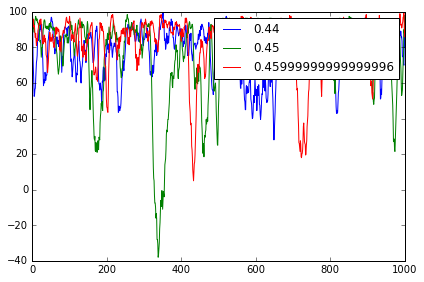

In [9]:
%%time
nx= 10
ny= 10
pyplot.figure()
NMC=1000
sp = numpy.ones([nx,ny])
Bstate= numpy.empty([10,NMC+1,nx,ny])
for i in range (1,4):
    sp = numpy.ones([nx,ny])
    alpha= 0.43+i/100
    state_i = ising_model_metropolis(sp, NMC, nx, ny, alpha)
    Bstate[i] = state_i
    pyplot.plot(smootharray(Bstate[i].sum(axis=(1,2))),label=alpha)
    pyplot.legend()
    pyplot.tight_layout()

In [10]:
def analysis_for_alpha(initial_state,NMC,alpha_mode):
    nx= len(initial_state)
    ny= len(initial_state[0])
        #those lists contain alpha's we would like to test. This is an easy way to rapidly scan the alpha'ss where the outcome
        #is predictable and to focus more on alphas near the critical value of phase transition
    #--------alpha lists ------#
    alpha_list =      [[0,100,200,300,400,420,440,460,480,500,600,700,800,900,1000],\
                      [300,350,375,400,410,415,420,425,430,435,440,445,450,455,460,470,480,490,500,600],\
                      [416,420,424,428,432,436,437,438,439,440,442,444,446,448,450,452,454,456,458,460],\
                      [0,20,40,60,80,100,120,140,160,180,200,300,500,700,750,800,850,900,950,1000]]
                    
    #--------------------------#
    n_steps = len(alpha_list[alpha_mode])
    magnetisation_alpha = numpy.empty([n_steps,3]) #this array will contain[mean magnetisation,variance of magnetisation, alpha]
    energy_alpha = numpy.empty([n_steps,2]) #this array will contain[mean energy,alpha]
    for i in range(0,n_steps):
        sp = initial_state.copy()
        alpha = alpha_list[alpha_mode][i]/1000
        print(int(i/n_steps*100) , '%') #This is probably the most frustrating algorithm in the world, as you'll never see 100%
        states_alpha = ising_model_metropolis(sp, NMC, nx, ny, alpha)
        ##----------Average magnetisation---------##
        av_magnetisation_i = numpy.average(states_alpha[50:])*nx*ny #Average on magnetisation- not using first 100 states
        magnetisation_alpha[i,0]= av_magnetisation_i
        magnetisation_alpha[i,2]= alpha
        ##----------Magnetisation variance--------##
        mag_per_state = numpy.empty(NMC+1)                           #Variance on magnetisation - not using first 100 states
        for j in range(0,NMC+1):                                     #We create an array containing magnetisation value for each state
            mag_per_state[j] = numpy.average(states_alpha[j])        
        var_magnetisation_i = numpy.var(mag_per_state[50:])         #We compute the variance on this array - not using first 50 states
        magnetisation_alpha[i,1] = var_magnetisation_i
        ##-----------Average energy---------------##
        energy_alpha[i,0] = average_energy(states_alpha[50:],alpha) #Average energy - not using first 50 states
        energy_alpha[i,1] = alpha
        ##--------------------------##
    mag_av_plot=pyplot.figure()
    mag_av_plot.suptitle('Magnetisation')
    pyplot.plot(magnetisation_alpha[:,2],magnetisation_alpha[:,0])
    mag_var_plot=pyplot.figure()
    mag_var_plot.suptitle('Variance')
    pyplot.plot(magnetisation_alpha[:,2],magnetisation_alpha[:,1])
    energy_plot = pyplot.figure()
    energy_plot.suptitle('Energy')
    pyplot.plot(energy_alpha[:,1],energy_alpha[:,0])
    return [magnetisation_alpha,energy_alpha]

# Analysis for alpha ranging from 0.3 to 0.5 - initial conditions: all spins upwards

In [11]:
nx = 25
ny = 25
NMC = 1000
alpha_mode = 1 #alpha within[0.3,0.5]

0 %
5 %
10 %
15 %
20 %
25 %
30 %
35 %
40 %
45 %
50 %
55 %
60 %
65 %
70 %
75 %
80 %
85 %
90 %
95 %
Wall time: 3min 22s


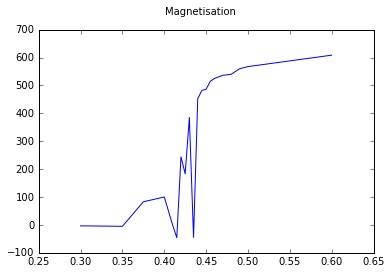

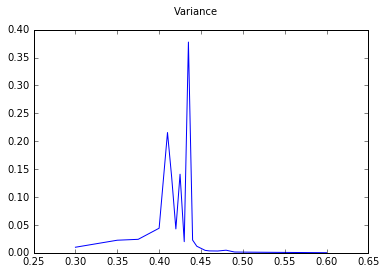

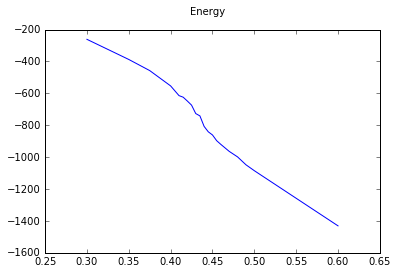

In [12]:
%%time
sp = numpy.ones([nx,ny])
initial_upwards=analysis_for_alpha(sp,NMC,alpha_mode)

In [13]:
print(initial_upwards[0]) #Magnetisation-variance-alpha

[[  -3.38065195    0.00997329    0.3       ]
 [  -5.10094637    0.02254408    0.35      ]
 [  82.76025237    0.02415008    0.375     ]
 [ 100.08307045    0.04406689    0.4       ]
 [  -0.0851735     0.21555123    0.41      ]
 [ -45.96950578    0.13523129    0.415     ]
 [ 244.11251314    0.04280215    0.42      ]
 [ 182.92218717    0.1408376     0.425     ]
 [ 384.8254469     0.01994297    0.43      ]
 [ -44.95373291    0.37766498    0.435     ]
 [ 452.32071504    0.02282942    0.44      ]
 [ 482.07886435    0.01177557    0.445     ]
 [ 486.18611987    0.0080386     0.45      ]
 [ 514.55625657    0.0043524     0.455     ]
 [ 524.87381703    0.00340031    0.46      ]
 [ 536.19242902    0.00320385    0.47      ]
 [ 539.83911672    0.00465393    0.48      ]
 [ 559.59305994    0.00141259    0.49      ]
 [ 567.3491062     0.0012245     0.5       ]
 [ 608.33543638    0.00015847    0.6       ]]


For nx,ny=25, from the arguments we gave before (searching for 50%,75% of max magnetization, low variance) we see the phase transition somewhere between [0.43:0.46]. This is a good evaluation of alpha. 

0 %
6 %
13 %
20 %
26 %
33 %
40 %
46 %
53 %
60 %
66 %
73 %
80 %
86 %
93 %
[-4366.22502623   388.13038905    -7.20706625] ax^2+bx+c
[-2593.56803364    94.24975814] ax+b
Wall time: 2min 30s


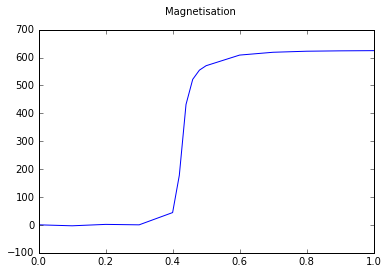

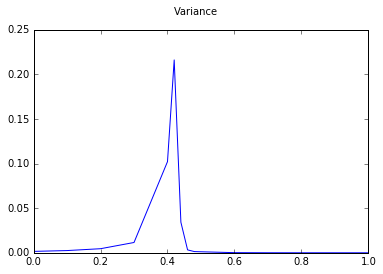

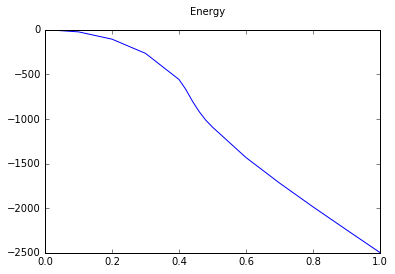

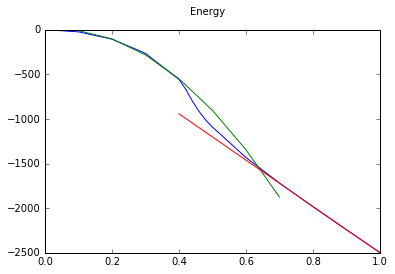

In [14]:
%%time 
sp = numpy.ones([nx,ny])
initial_upwards_energy=analysis_for_alpha(sp,NMC,0)

quadratic_part = numpy.polyfit(initial_upwards_energy[1][:,1][initial_upwards_energy[1][:,1]<=0.4],initial_upwards_energy[1][:,0][initial_upwards_energy[1][:,1]<=0.4],2)
print(quadratic_part, 'ax^2+bx+c')
linear_part = numpy.polyfit(initial_upwards_energy[1][:,1][initial_upwards_energy[1][:,1]>=0.7],initial_upwards_energy[1][:,0][initial_upwards_energy[1][:,1]>=0.7],1)
print(linear_part, 'ax+b')

x = numpy.arange(0.,1.1,0.1)
energy_plot = pyplot.figure()
energy_plot.suptitle('Energy')
pyplot.plot(initial_upwards_energy[1][:,1],initial_upwards_energy[1][:,0])
pyplot.plot(x[:8],quadratic_part[0]*x[:8]**2 + quadratic_part[1]*x[:8]+ quadratic_part[2])
pyplot.plot(x[4:],linear_part[0]*x[4:]+linear_part[1])

In [15]:
polyn = [quadratic_part[0],quadratic_part[1]-linear_part[0],quadratic_part[2]-linear_part[1]]
print(numpy.roots(polyn)) #Compute the intersection between the parabole and the line.

[ 0.64698537  0.0359154 ]


Interestingly enough, we observe that the instersection is far beyond the phase transition point. This is not due to statistical errors, increasing the NMC,nx and ny doesn't help. We didn't find the reason of this oddity. We won't be later using this method to estimate alpha.

# Analysis for alpha ranging from 0 to 1 - Initial conditions: All spins oriented randomly

0 %
5 %
10 %
15 %
20 %
25 %
30 %
35 %
40 %
45 %
50 %
55 %
60 %
65 %
70 %
75 %
80 %
85 %
90 %
95 %
Wall time: 4min 43s


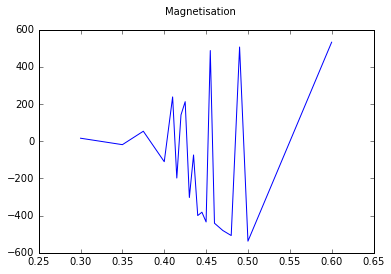

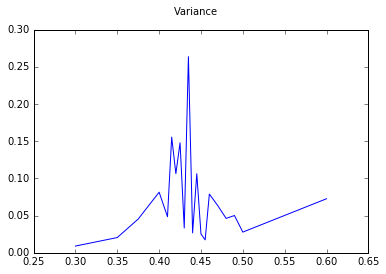

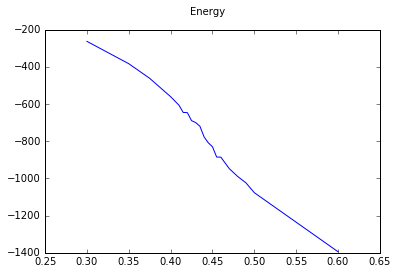

In [16]:
%%time
sp = initial_states(nx,ny)
initial_random=analysis_for_alpha(sp,NMC,alpha_mode)

In [17]:
print(numpy.absolute(initial_random[0])) #Absolute Magnetisation-variance-alpha

[[  16.03890641    0.00905342    0.3       ]
 [  18.59621451    0.02050176    0.35      ]
 [  53.61409043    0.04537466    0.375     ]
 [ 110.22607781    0.08143866    0.4       ]
 [ 238.09568875    0.0485259     0.41      ]
 [ 197.95057834    0.15550719    0.415     ]
 [ 141.27760252    0.10636515    0.42      ]
 [ 212.53732913    0.14784685    0.425     ]
 [ 302.78128286    0.03331018    0.43      ]
 [  74.04100946    0.26363722    0.435     ]
 [ 399.74658254    0.02677137    0.44      ]
 [ 381.7276551     0.10627787    0.445     ]
 [ 434.0851735     0.02536656    0.45      ]
 [ 487.41640379    0.01735723    0.455     ]
 [ 440.91167192    0.07893354    0.46      ]
 [ 480.15667718    0.06353277    0.47      ]
 [ 507.16193481    0.04626747    0.48      ]
 [ 506.32912723    0.05010429    0.49      ]
 [ 537.38696109    0.02783786    0.5       ]
 [ 532.20504732    0.07265324    0.6       ]]


Magnetized systems point randomly upwards or downwards. We estimate alpha to be within [0.43:0.45] 

# Analysis for alpha ranging from 0 to 1 - Initial conditions - upwards on boundary, random interior

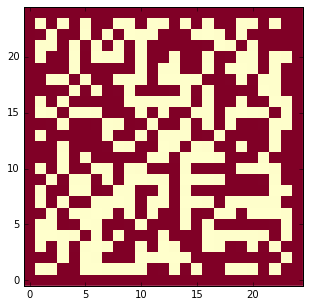

In [18]:
random_int_bc_up = initial_states(nx,ny) #initial state - all spins oriented upward
random_int_bc_up[:,-1]= 1
random_int_bc_up[-1,:] = 1
random_int_bc_up[:,0] = 1
random_int_bc_up[0,:] = 1
pyplot.figure(figsize=(5,5))
pyplot.imshow(random_int_bc_up,interpolation="None",origin='lower',cmap='YlOrRd')

0 %
5 %
10 %
15 %
20 %
25 %
30 %
35 %
40 %
45 %
50 %
55 %
60 %
65 %
70 %
75 %
80 %
85 %
90 %
95 %
Wall time: 4min 43s


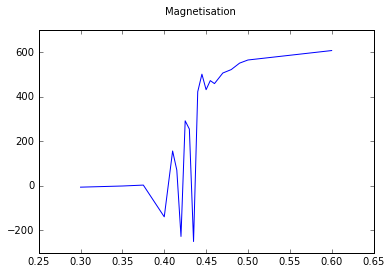

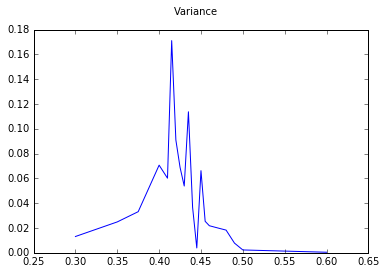

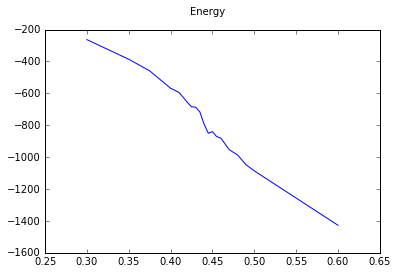

In [19]:
%%time
random_int_bc_up=analysis_for_alpha(random_int_bc_up,NMC,alpha_mode)

Analysis for alpha ranging from 0 to 1
Initial state: boundary pointing upwards, interior pointing downwards

In [20]:
print(random_int_bc_up[0])

[[  -5.9232387     0.01313824    0.3       ]
 [  -0.74342797    0.02491197    0.35      ]
 [   3.34490011    0.03315858    0.375     ]
 [-138.83175605    0.07068071    0.4       ]
 [ 156.16088328    0.06016765    0.41      ]
 [  70.53732913    0.17111543    0.415     ]
 [-226.79390116    0.09097784    0.42      ]
 [ 291.26919033    0.0689041     0.425     ]
 [ 254.40694006    0.05385782    0.43      ]
 [-249.50052576    0.11373197    0.435     ]
 [ 421.5573081     0.03660059    0.44      ]
 [ 500.2555205     0.00390656    0.445     ]
 [ 430.74763407    0.06624228    0.45      ]
 [ 471.44794953    0.02539862    0.455     ]
 [ 458.10410095    0.02183126    0.46      ]
 [ 505.5362776     0.02004207    0.47      ]
 [ 520.8044164     0.01830591    0.48      ]
 [ 549.79915878    0.00782638    0.49      ]
 [ 563.83491062    0.00230023    0.5       ]
 [ 606.10410095    0.00044702    0.6       ]]


Boundary conditions have favorized the magnetization of the system upwards. We estimate alpha to be within [0.43:0.45]

We gave several methods to estimate alpha. 2 of them consisted into looking at magnetization or it's variance  for alpha close to critical value. Due to the highly fluctuating nature of the system near this value, this is a very unsure method. We do not fully understand the behavior of those fluctuations and the time needed to make more precise statistical evaluations grows rapidly. We tried to bypass this difficulty by evaluating energy of the states for very low and very high alpha's. Unfortunatelly, this didn't work. Despite all those difficulties, we could provide an estimation of alpha. It should be somewhere in [0.43:0.46]. The value we are supposed to be find is 0.440 (Onsager's solution).